In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Algorithmes d’apprentissage non supervisé<br>
    </h1>
    MovieLens - Système de recommendations de films<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <b>Michèle de La Sablonnière</b><br>
    <br>
    420-A58<br>
    <br>
</center>

# Introduction
    
Nous avons choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle décrit les notations des utilisateurs de MovieLens; un service de recommandations de films. Elle a été préalablement traité afin d'extraire les informations intéressantes pour un système de suggestions par clusterisation et règles d'associations. Les résultats se trouvent dans 2 fichiers. 

<br>**movies_pretraitement.csv**

Ce fichier contient les métadonnées pertinentes pour 1 film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock"> movieId, imdbId, title, year, year_category, year_boxcox_std, rating_mode, genres, genres_tfidf_*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|movieId| Identifiant du film dans cette base de données.|
|imdbId| Identifiant du film dans [Internet Movie Database](http://www.imdb.com).|
|title| Titre du film. Peut contenir l'année de parution.|
|year| Année de parution du film.|
|year_category| **year** catégorisé. La base de données a 3 modalités.|
|year_boxcox_std| **year** transformé par BoxCox et StandardScaler.|
|rating_mode| Nombre d'étoiles attribuées avec une granularité de $\frac{1}{2}$. Entre [0.5 et 5] |
|genres| Liste de mots séparés par un 'pipe' (\|). La base de données a 18 modalités. |
|genres_tfidf_*| **genres** encodé selon TF-IDF. Ici l'étoile représente toutes les modalités de **genres**. |
</div>

<br>**ratings_pretraitement.csv**

Ce fichier contient les métadonnées de chaque film. Chaque ligne a ce format:

<div class="indentation">
<div class="fixblock">userId, films*</div>

|Attribut|<center>Description</center>|
|:-|:---|
|userId| Identifiant de l'utilisateur.|
|films*| Identifiant du film. Ici l'étoile représente 1 colonne par film |
</div>

<br>

Chaque base de données sera examinée indépendemment. Nous allons d'abord valider les prétraitements. Par la suite, dans un but de restreindre la portée du projet, nous allons faire une *clusterization* sur (**genres**, **rating_mode**) et **genres_tfidf\***. Finalement nous allons examiner les règles d'associations avec **ratings_pretraitement.csv**.

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances

#
# imports faisant partie de nos propres modules
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.jupyter as jup

# Lecteure des données

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

# imdbId doit etre garde en string (leading 0)
movies_df = pd.read_csv("dataset/movies_pretraitement.csv", dtype={"imdbId": str})

print("Movies", movies_df.shape)
print("Head")
display(movies_df.head().round(2))
clstr.show_types(movies_df)

Movies (9460, 26)
Head


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
0,1,0114709,Toy Story (1995),1995,"[1975, 2001]",-0.19,4.0,Animation|Adventure|Fantasy|Comedy|Children,0.0,0.41,...,0.48,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2,0113497,Jumanji (1995),1995,"[1975, 2001]",-0.19,4.0,Fantasy|Children|Adventure,0.0,0.51,...,0.59,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,3,0113228,Grumpier Old Men (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy|Romance,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.82,0.0,0.0,0.0,0.0
3,4,0114885,Waiting to Exhale (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy|Drama|Romance,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.72,0.0,0.0,0.0,0.0
4,5,0113041,Father of the Bride Part II (1995),1995,"[1975, 2001]",-0.19,3.0,Comedy,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


Types


,movieId,imdbId,title,year,year_category,year_boxcox_std,rating_mode,genres,genres_tfidf_Action,genres_tfidf_Adventure,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Type,int64,object,object,int64,object,float64,float64,object,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


* 9460 individus 
* 26 variables (elles correspondent bien à la description)
* **title**, **year_category** et **genres** sont de type qualitatif. Les autres variables sont de type quantitatif. Noter que **rating_mode** représente bien une variable qualitative par nature mais est gardé quantitatif pour faciliter certaines manipulations.

Nous allons vérifier les valeurs manquantes et doublons.

In [4]:
#
# validation valeurs manquantes doublons
#
print("Avant retrait doublons:", movies_df.shape)
movies_df.drop_duplicates(inplace=True)
print("Après retrait doublons:", movies_df.shape)

clstr.show_na(movies_df);

Avant retrait doublons: (9460, 26)
Après retrait doublons: (9460, 26)
Valeur manquante 0 (0.0%)


Aucun doublon et aucune valeur manquante. Nous allons vérifier les modalités des variables qualitatives.

In [5]:
#
# Verification des modalites (rating_mode est egalement inclu pour valider
# s'il correspond bien a sa description)
#
def get_mods(values, name=""):
    if isinstance(values, pd.Series):
        series = pd.Series(values.unique())
        series.name = values.name
    else:
        series = pd.Series(values)
        series.name = name
    
    return series.to_frame()

genres_ohe_df = movies_df.genres.str.get_dummies(sep=configs.dataset.genre_splitter)
html_ = jup.horizontify(get_mods(movies_df.year_category),
                        get_mods(movies_df.rating_mode),
                        get_mods(genres_ohe_df.columns, name="genres"))
print("Modalités")
jup.display_html(html_)

Modalités


,year_category
0,"[1975, 2001]"
1,"[1902, 1974]"
2,"[2002, 2018]"
,rating_mode
0,4.0
1,3.0
2,5.0
3,2.0
4,4.5
5,3.5


## Distributions - variables quantitatives

Stats générales - variables quantitatives


,count,mean,std,min,25%,50%,75%,max
year,9460.0,1994.64,18.38,1902.00,1988.00,1999.00,2008.00,2018.00
year_boxcox_std,9460.0,-0.00,1.00,-2.68,-0.61,0.08,0.79,1.78
rating_mode,9460.0,3.48,0.97,0.50,3.00,3.50,4.00,5.00
genres_tfidf_Action,9460.0,0.11,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Adventure,9460.0,0.07,0.20,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Animation,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Children,9460.0,0.04,0.16,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Comedy,9460.0,0.24,0.34,0.00,0.00,0.00,0.47,1.00
genres_tfidf_Crime,9460.0,0.08,0.23,0.00,0.00,0.00,0.00,1.00
genres_tfidf_Documentary,9460.0,0.04,0.20,0.00,0.00,0.00,0.00,1.00



Distributions - variables quantitatives


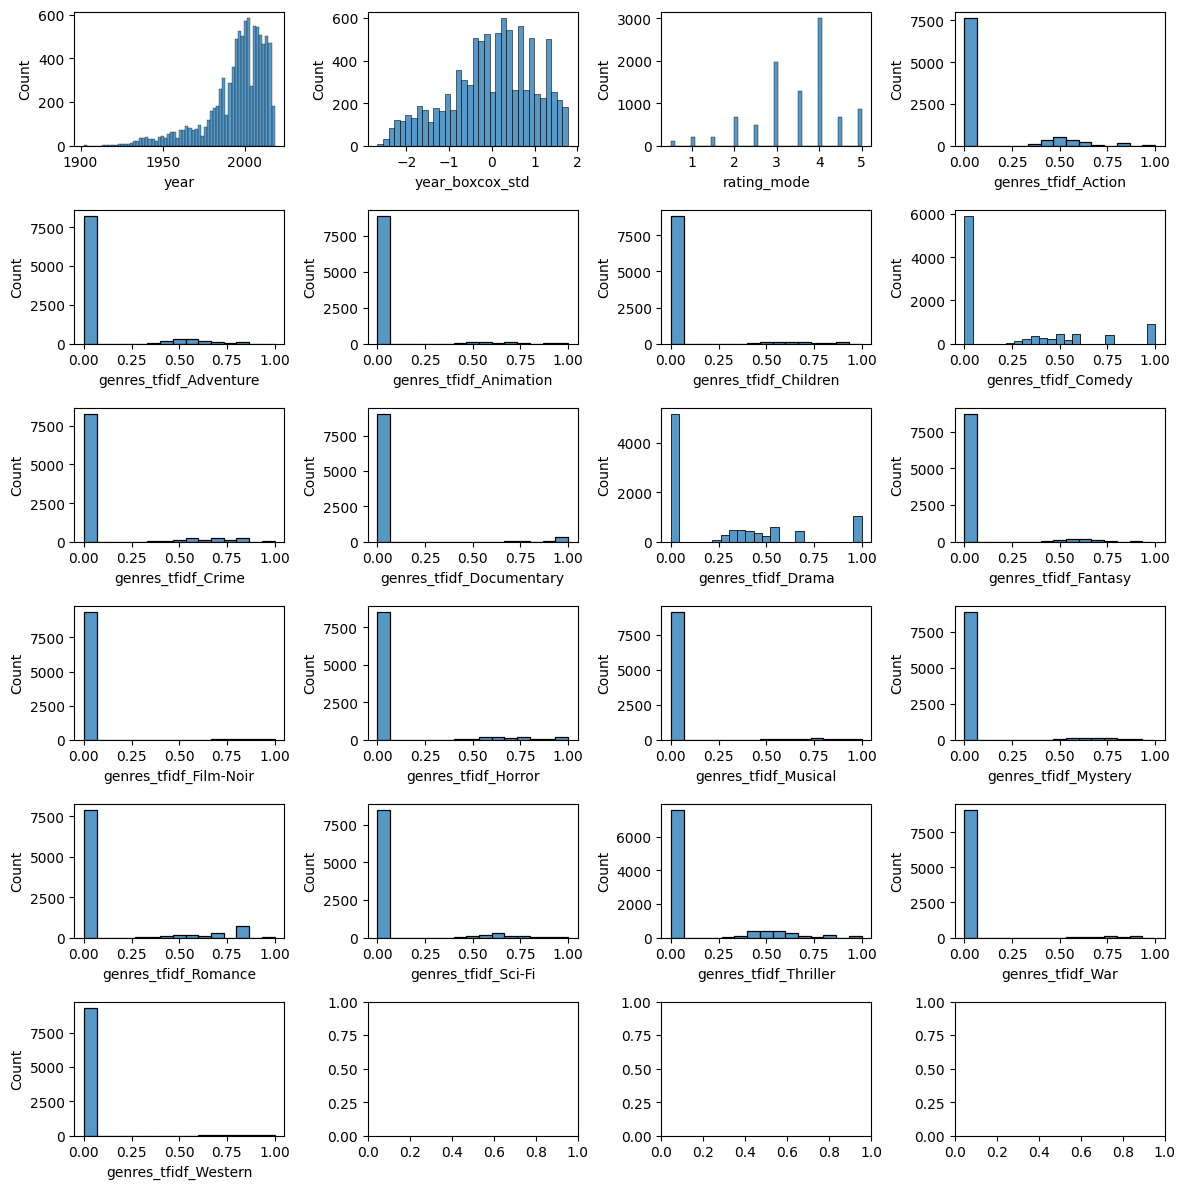

In [6]:
# on enleve movieId, imdbId et title
quant_df = movies_df.iloc[:, 3:].select_dtypes(exclude="object")

print("Stats générales - variables quantitatives")
display(quant_df.describe().T.round(2))
print()
print("Distributions - variables quantitatives")
clstr.show_distributions(quant_df, num_cols=4, figsize=(12, 12))

TODO: recopier analyse de l'autre notebook

* tf-idf est plein de 0 et devrait pas etre utiliser avec le numeriques
* sinon year_boxcox_std est ben correcte
* rating_mode est mieux dans qualitatif

# Valeurs aberrantes et *outliers* - variables quantitatives

IQR outliers par variable, eta: 1.5


,year,year_boxcox_std,rating_mode,genres_tfidf_Action,genres_tfidf_Adventure,genres_tfidf_Animation,genres_tfidf_Children,genres_tfidf_Comedy,genres_tfidf_Crime,genres_tfidf_Documentary,...,genres_tfidf_Fantasy,genres_tfidf_Film-Noir,genres_tfidf_Horror,genres_tfidf_Musical,genres_tfidf_Mystery,genres_tfidf_Romance,genres_tfidf_Sci-Fi,genres_tfidf_Thriller,genres_tfidf_War,genres_tfidf_Western
Count,562.0,0.0,310.0,1818.0,1239.0,573.0,626.0,0.0,1189.0,428.0,...,758.0,85.0,933.0,334.0,569.0,1562.0,964.0,1871.0,375.0,165.0
%,5.9,0.0,3.3,19.2,13.1,6.1,6.6,0.0,12.6,4.5,...,8.0,0.9,9.9,3.5,6.0,16.5,10.2,19.8,4.0,1.7



IQR outliers 7309 (77.3%), eta: 1.5

Outliers boxplots, eta: 1.5


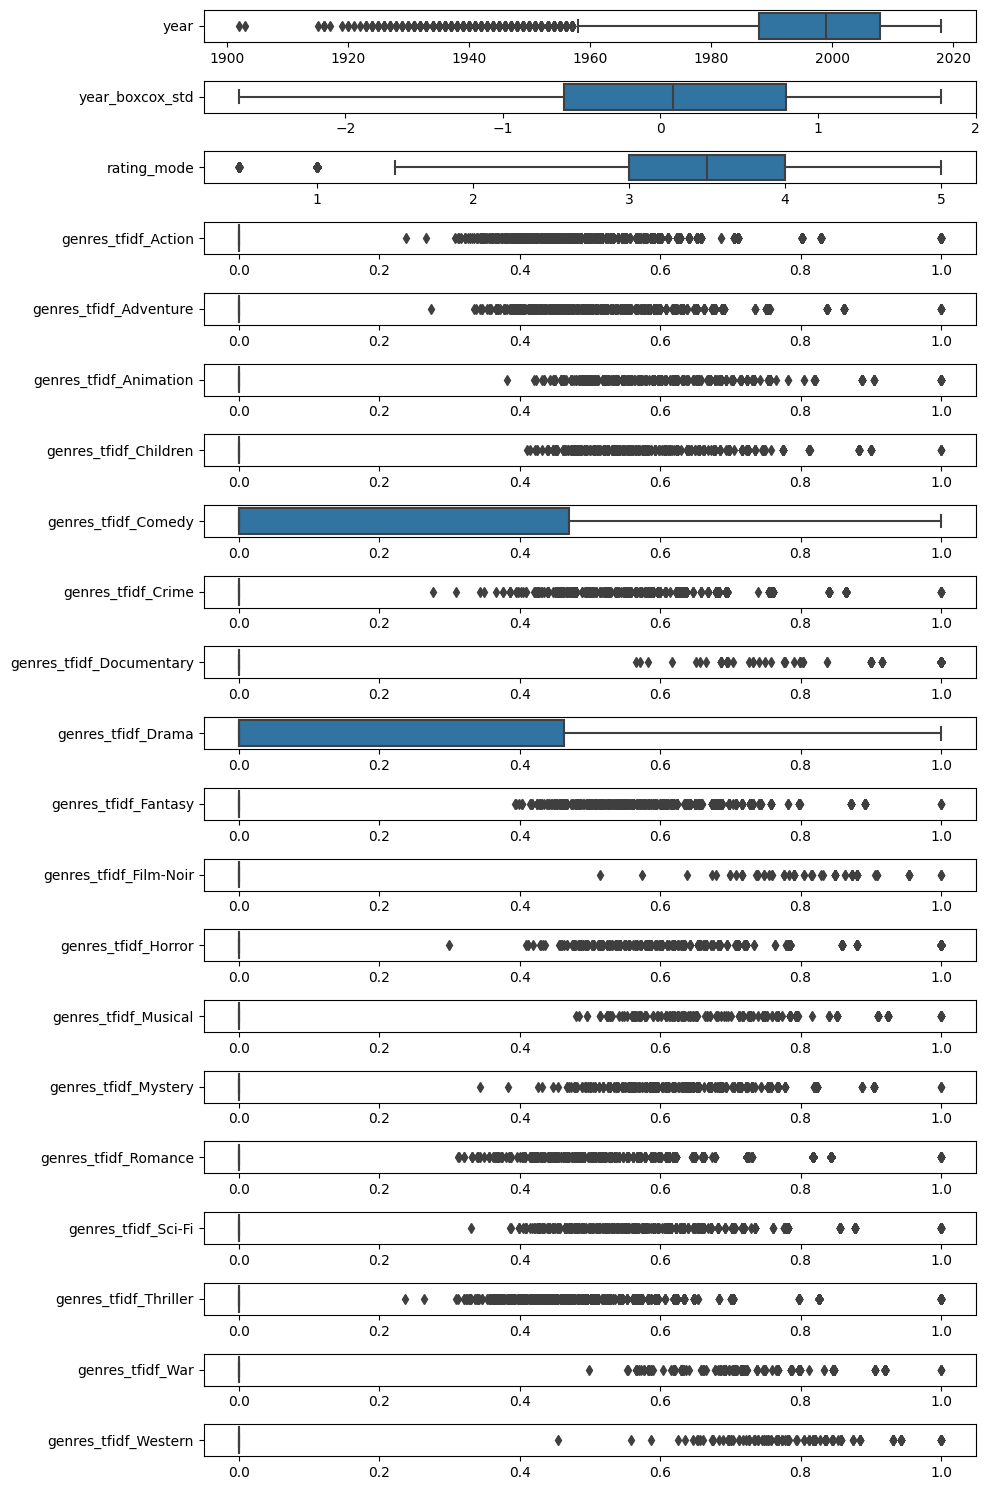

In [7]:
clstr.show_outliers_iqr(quant_df, 
                        eta=1.5,
                        boxlists=[[c] for c in quant_df.columns],
                        figsize=(10, 15));

Groso modo, year_boxcox_std est ok. Les outliers dans tf-idf ne le sont pas a notre avis. Le 0 bouge tout. Ca confirme notre intuition de separer. 

# Distributions - variables qualitatives

Distributions - variables qualitatives


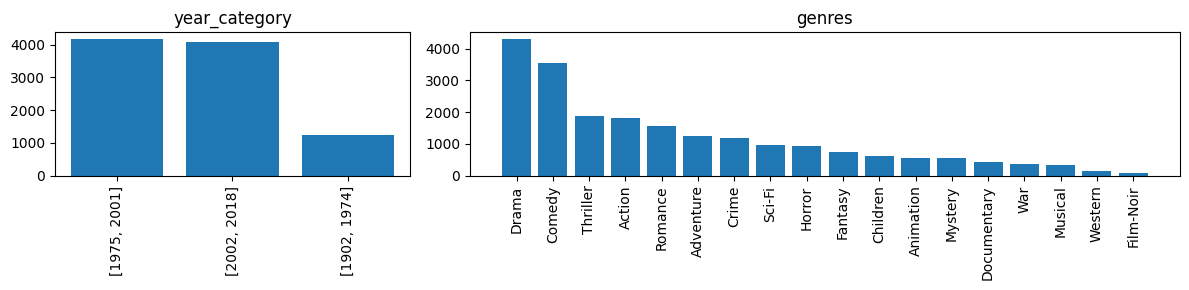

In [8]:
year_category_count = movies_df.year_category.value_counts()
genres_count = genres_ohe_df.sum(axis=0)
genres_count.sort_values(ascending=False, inplace=True)

print("Distributions - variables qualitatives")

_, axes = plt.subplots(1, 
                       2, 
                       width_ratios=[1, 2],
                       figsize=(12, 3))
axes[0].bar(year_category_count.index, year_category_count)
axes[0].tick_params(axis="x", labelrotation=90)
axes[0].set_title("year_category")

axes[1].bar(genres_count.index, genres_count)
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("genres")
             
plt.tight_layout()
plt.show()

* Forte proportion dans Drama et Comedy

# Corrélation et reduction de dimensions

TODO

# Clustering

(genres, rating_mode)  genres_tfidf*. 

In [9]:
#
# fanalysis ne permet pas de passer notre one hot encoder
# ajouter ces classes pour encapsuler cette fonctionalite
#
from fanalysis.base import Base

class MCA_from_dummies(Base):
    def __init__(self, n_components=None, row_labels=None, var_labels=None, stats=True):
        Base.__init__(self, n_components, row_labels, None, stats)
        self.var_labels = var_labels
        
    def prefit(self, X, X_dummies):
        # Set columns prefixes
        self.n_vars_ = X.shape[1]
        self.prefixes_ = self.prefixes_ = [str(x) + "_" for x in self.var_labels]
        self.col_labels_short_temp_ = [x.split("_")[-1] for x in X_dummies.columns]
        self.col_labels_temp_ = X_dummies.columns
                
        # Dummy variables creation
        self.n_categories_ = X_dummies.shape[1]
    
    def fit(self, X_dummies, y=None):
        # Fit a Factorial Analysis to the dummy variables table
        self.r_ = np.sum(X_dummies, axis=1).reshape(-1, 1)
        Base.fit(self, X_dummies, y=None)
        
        # Adjustment of the number of components
        n_eigen = self.n_categories_ - self.n_vars_
        if (self.n_components_ > n_eigen):
            self.n_components_ = n_eigen
            self.eig_ = self.eig_[:, :self.n_components_]
            self.row_coord_ = self.row_coord_[:, :self.n_components_]
            self.col_coord_ = self.col_coord_[:, :self.n_components_]
            if self.stats:
                self.row_contrib_ = self.row_contrib_[:, :self.n_components_]
                self.col_contrib_ = self.col_contrib_[:, :self.n_components_]
                self.row_cos2_ = self.row_cos2_[:, :self.n_components_]
                self.col_cos2_ = self.col_cos2_[:, :self.n_components_]

        # Set col_labels_short_
        self.col_labels_short_ = self.col_labels_short_temp_
        
        # Set col_labels_
        self.col_labels_ = self.col_labels_temp_        
        
        self.model_ = "mca"
        
        return self
                        
def acm_init(data, n_components, data_dummies=None):
    if data_dummies is None:
        acm = MCA(n_components=n_components,
                  row_labels=data.index,
                  var_labels=data.columns)
        acm.fit(data.to_numpy())
    else:
        acm = MCA_from_dummies(n_components=n_components,
                               row_labels=data.index,
                               var_labels=data.columns)
        
        acm.prefit(data, data_dummies)        
        acm.fit(data_dummies.to_numpy())
    
    return acm

def acm_analysis(data, data_dummies=None, figsize=(4, 2.5)):
    """
    Le threshold est ~60% sur cumul var. expliquee
    """
    acm = acm_init(data, None, data_dummies=data_dummies)

    threshold = 1 / acm.n_vars_
    eig_vals = acm.eig_[0]
    eig_th = eig_vals[eig_vals > threshold]

    print("Valeurs propres:")
    print(acm.eig_[0].round(4))
    print()
    print(f"Valeurs propres > {round(threshold, 4)} (1 / p):")
    print(eig_th.round(4))
    print()
    print("Variance expliquee %:")
    print(acm.eig_[1].round(1))
    print()
    print("Variance expliquee cumul. %:")
    print(acm.eig_[2].round(1))
    print()

    num_eigval = len(acm.eig_[0])

    plt.figure(figsize=figsize)
    plt.plot(range(1, num_eigval + 1), acm.eig_[0], marker=".")
    plt.grid(True)
    plt.xlabel("# axe factoriel")
    plt.ylabel("Valeur propre")
    plt.show()

In [10]:
#
# faire le one hot encodage nous meme
# genres prend plus d'une modalite a la fois
#
rating_mode_ohe = movies_df.rating_mode.astype(str).str.get_dummies()

# acm_data_ohe_df = pd.concat([rating_mode_ohe, genres_ohe_df], axis=1)
# acm_data_df = movies_df[["rating_mode", "genres"]]

acm_data_ohe_df = pd.concat([rating_mode_ohe], axis=1)
acm_data_df = movies_df[["rating_mode"]]

In [11]:
from fanalysis.mca import MCA

data_acm_df = movies_df.rating_mode.astype(str).to_frame()

# aa = MCA(n_components=10, 
#          row_labels=data_acm_df.index,
#          var_labels=data_acm_df.columns)
# aa.fit(data_acm_df.to_numpy());

# clstr.show_clusters(aa.row_coord_[:, [0, 1]], 
#                     aa.row_labels_, 
#                     np.zeros(data_acm_df.shape[0], dtype=np.int64),
#                     text_alpha=0,
#                     marker_size=1)

In [12]:
# acm_analysis(movies_df[["genres"]], data_dummies=genres_ohe_df)

# cc = acm_init(movies_df[["genres"]], 10, data_dummies=genres_ohe_df)
# clstr.show_clusters(cc.row_coord_[:, [0, 1]], 
#                     cc.row_labels_, 
#                     np.zeros(data_acm_df.shape[0], dtype=np.int64),
#                     text_alpha=0,
#                     marker_size=1,
#                     figsize=(4, 2.5))

In [13]:
# tsvd_sample = TruncatedSVD(n_components=genres_ohe_df.shape[1])
# tsvd_sample_df = tsvd_sample.fit_transform(genres_ohe_df)
# ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

# plt.figure(figsize=(4, 2.5))
# plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
# plt.grid(True)
# plt.show()

# plt.scatter(tsvd_sample_df[:, 0], tsvd_sample_df[:, 1], s=0.5)
# plt.show()

In [14]:
genres_tfidf_cols = movies_df.columns.str.contains("genres_tfidf_")
genres_tfidf_cols = movies_df.columns[genres_tfidf_cols]
genres_tfidf_df = movies_df[genres_tfidf_cols]

# tsvd_sample = TruncatedSVD(n_components=18)
# tsvd_sample_df = tsvd_sample.fit_transform(genres_tfidf_df)
# ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

# plt.figure(figsize=(4, 2.5))
# plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
# plt.grid(True)
# plt.show()

# plt.scatter(tsvd_sample_df[:, 0], tsvd_sample_df[:, 1], s=0.5)
# plt.show()

In [20]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

frac = 0.7

mds_data_df = genres_ohe_df.sample(frac=frac)
# mds_data_df = genres_tfidf_df.sample(frac=frac)

distances = pairwise_distances(mds_data_df, metric="cosine", n_jobs=-1)

MDS: 905.59 s


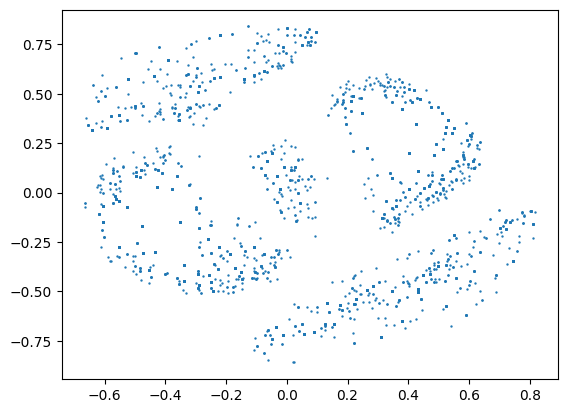

In [21]:
mds_ = MDS(n_components=2, 
           dissimilarity="precomputed", 
           normalized_stress=False,
           n_jobs=-1)

with hlp.Profile() as mds_profile:
    coords = mds_.fit_transform(distances)

print("MDS:", mds_profile.round_duration(2), "s")
plt.scatter(coords[:, 0], coords[:, 1], s=0.5)
plt.show()

In [17]:
# tsvd_sample = TruncatedSVD(n_components=genres_ohe_df.shape[1])
# tsvd_sample_df = tsvd_sample.fit_transform(genres_ohe_df)
# ss = np.cumsum(tsvd_sample.explained_variance_ratio_)

# plt.figure(figsize=(4, 2.5))
# plt.plot(range(1, ss.shape[0] + 1), ss, marker=".")
# plt.grid(True)
# plt.show()

# plt.scatter(tsvd_sample_df[:, 0], tsvd_sample_df[:, 1], s=0.5)
# plt.show()